In [303]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("./paper.mplstyle")
from scipy.optimize import curve_fit
power_law = lambda x, c, gamma: c*x**(-gamma) # gamma is power law exponent
exponential_law = lambda x, c, T: c*np.exp(-x/T) # T is time scale
gaussian = lambda x, mu, sigma: 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)
from gol import SporeLife
from gol import ALIVE, SPORE, DEAD
from util import random_init_grid

# Transitions

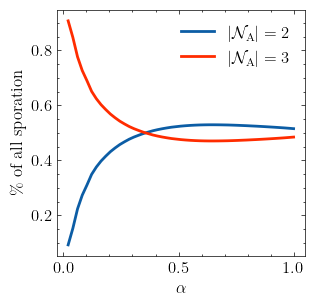

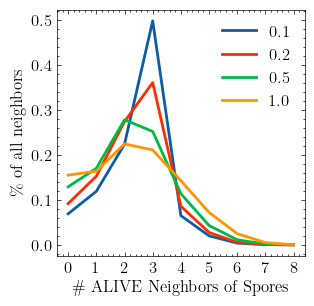

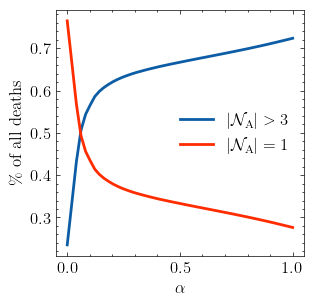

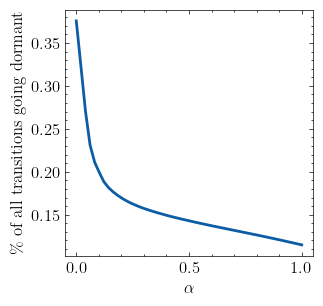

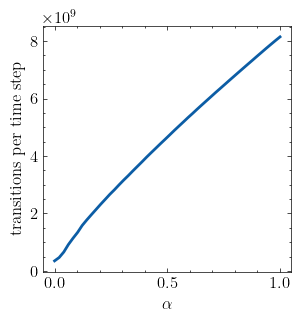

In [111]:
base_path = "data/spore-life/state-transitions/transition-table/grid-size-300/"
# base_path = "data/spore-life/state-transitions/transition-table"
alphas = np.loadtxt(os.path.join(base_path, "alpha-range.dat"))
sporation_two_an = np.array([np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[2, 2] for alpha in alphas])
sporation_three_an = np.array([np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[2, 3] for alpha in alphas])
fig, ax = plt.subplots()
ax.set(xlabel=r"$\alpha$", ylabel=r"\% of all sporation")
ax.plot(alphas[1:], sporation_two_an[1:]/(sporation_two_an+sporation_three_an)[1:],
        label=r"$|\mathcal{N}_\mathrm{A}| = 2$")
ax.plot(alphas[1:], sporation_three_an[1:]/(sporation_two_an+sporation_three_an)[1:],
        label=r"$|\mathcal{N}_\mathrm{A}| = 3$")
ax.legend()

fig, ax = plt.subplots() # PEAK SIND BLINKER! siehe simulation.py
ax.set(xlabel=r"\# ALIVE Neighbors of Spores", ylabel=r"\% of all neighbors", xticks=range(9))
for i, alpha in enumerate([.102, .204, .51, 1]):
# for i, alpha in enumerate([.103, .207, .517, 1]):
    data = np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[2, :]
    ax.plot(range(9), data/np.sum(data), label="%.1f"%alpha)
ax.legend()

dead_overcrowding = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[1, 4:]) for alpha in alphas])
dead_lonelyness = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[1, 0:2]) for alpha in alphas])
fig, ax = plt.subplots()
ax.set(xlabel=r"$\alpha$", ylabel=r"\% of all deaths")
ax.plot(alphas, dead_overcrowding/(dead_overcrowding+dead_lonelyness),
        label=r"$|\mathcal{N}_\mathrm{A}| > 3$")
ax.plot(alphas, dead_lonelyness/(dead_overcrowding+dead_lonelyness),
        label=r"$|\mathcal{N}_\mathrm{A}| = 1$")
ax.legend()

go_dormant = np.array([np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[1, 1] for alpha in alphas])
_mask = np.bool_([[0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 1, 1, 1, 1], [0, 0, 1, 1, 0, 0, 0, 0, 0]])
all_transitions = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask]) for alpha in alphas])
fig, ax = plt.subplots()
ax.set(xlabel=r"$\alpha$", ylabel=r"\% of all transitions going dormant")
ax.plot(alphas, go_dormant/all_transitions)

_mask = np.bool_([[0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 1, 1, 1, 1], [0, 0, 1, 1, 0, 0, 0, 0, 0]])
all_transitions = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask]) for alpha in alphas])
fig, ax = plt.subplots()
ax.set(xlabel=r"$\alpha$", ylabel=r"transitions per time step")
ax.plot(alphas, all_transitions)

# Killed through Stochasticity

In [310]:
t_max = 10_000; t_trans = 200; runs = 30; grid_size = 300
base_path = "data/spore-life/state-transitions/transition-table/grid-size-300/"
alphas = np.loadtxt(os.path.join(base_path, "alpha-range.dat"))

transitions_to_alive_2an = np.array([np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[2, 2] for alpha in alphas])/((t_max-t_trans)*runs)
transitions_to_alive_3an = np.array([np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[2, 3] for alpha in alphas])/((t_max-t_trans)*runs)
spore_counts = np.array([np.mean(np.loadtxt(os.path.join("data/spore-life/time-series", f"grid-size-{grid_size}/spore", "alpha-%.3f.dat"%alpha))[:, t_trans:]) for alpha in alphas])

def killed_through_stochasticity(sl: SporeLife, t_max, t_trans):
    data = np.zeros(t_max+1-t_trans)
    sl.step_until(t_trans)
    while sl.t < t_max:
        determ_grid = sl.deterministic_step(silent=True)
        determ_spores = np.count_nonzero(determ_grid == SPORE)
        sl.step()
        data[sl.t-t_trans] = determ_spores - sl.spore_count
    return data

transitions_to_dead = np.zeros(len(alphas))
for i, alpha in enumerate(alphas):
    print(alpha, end=" ")
    sl = SporeLife(random_init_grid(grid_size), alpha=alpha)
    transitions_to_dead[i] = np.mean(killed_through_stochasticity(sl, t_max, t_trans))

0.0 0.02040816326530612 0.04081632653061224 0.061224489795918366 0.08163265306122448 0.1020408163265306 0.12244897959183673 0.14285714285714285 0.16326530612244897 0.18367346938775508 0.2040816326530612 0.22448979591836732 0.24489795918367346 0.26530612244897955 0.2857142857142857 0.3061224489795918 0.32653061224489793 0.3469387755102041 0.36734693877551017 0.3877551020408163 0.4081632653061224 0.42857142857142855 0.44897959183673464 0.4693877551020408 0.4897959183673469 0.5102040816326531 0.5306122448979591 0.5510204081632653 0.5714285714285714 0.5918367346938775 0.6122448979591836 0.6326530612244897 0.6530612244897959 0.673469387755102 0.6938775510204082 0.7142857142857142 0.7346938775510203 0.7551020408163265 0.7755102040816326 0.7959183673469387 0.8163265306122448 0.836734693877551 0.8571428571428571 0.8775510204081632 0.8979591836734693 0.9183673469387754 0.9387755102040816 0.9591836734693877 0.9795918367346939 1.0 

/var/folders/6p/pg8nb3s56dldh08p9t61yss40000gn/T/ipykernel_98342/465614952.py:4: RuntimeWarning: invalid value encountered in divide
  tot_trans = transitions_to_alive_2an/spore_counts + transitions_to_alive_3an/spore_counts + transitions_to_dead/spore_counts
/var/folders/6p/pg8nb3s56dldh08p9t61yss40000gn/T/ipykernel_98342/465614952.py:4: RuntimeWarning: divide by zero encountered in divide
  tot_trans = transitions_to_alive_2an/spore_counts + transitions_to_alive_3an/spore_counts + transitions_to_dead/spore_counts
/var/folders/6p/pg8nb3s56dldh08p9t61yss40000gn/T/ipykernel_98342/465614952.py:7: RuntimeWarning: invalid value encountered in divide
  ax.plot(alphas, transitions_to_alive_2an/spore_counts, label=r"2")
/var/folders/6p/pg8nb3s56dldh08p9t61yss40000gn/T/ipykernel_98342/465614952.py:8: RuntimeWarning: invalid value encountered in divide
  ax.plot(alphas, transitions_to_alive_3an/spore_counts, label=r"3")
/var/folders/6p/pg8nb3s56dldh08p9t61yss40000gn/T/ipykernel_98342/465614952.

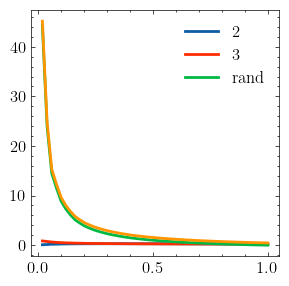

In [341]:
base_path = "data/spore-life/state-transitions/transition-table/grid-size-300/"
alphas = np.loadtxt(os.path.join(base_path, "alpha-range.dat"))

tot_trans = transitions_to_alive_2an/spore_counts + transitions_to_alive_3an/spore_counts + transitions_to_dead/spore_counts

fig, ax = plt.subplots()
ax.plot(alphas, transitions_to_alive_2an/spore_counts, label=r"2")
ax.plot(alphas, transitions_to_alive_3an/spore_counts, label=r"3")
ax.plot(alphas, transitions_to_dead/spore_counts, label=r"rand")
ax.plot(alphas, tot_trans)
ax.legend()

# Lifetime Distribution of Spores

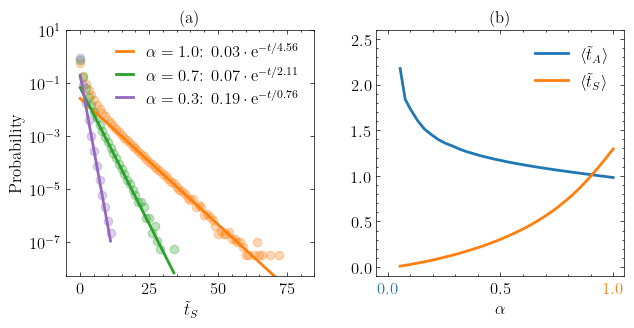

In [362]:
from collections import Counter
from lifetime_distribution import lifetime_distribution

base_path = "data/spore-life/avg-lifetimes/"

N = 300; t_max = 10_000; t_trans = 200

def avg_lifetime(state, N, t_max, t_trans, alpha):
    sl = SporeLife(random_init_grid(N), alpha=alpha)
    distr: Counter = lifetime_distribution(state, sl, t_max, t_trans)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    return np.sum(vals*counts)/np.sum(counts)

fig, (axl, axr) = plt.subplots(figsize=(7.2, 3.2), ncols=2)
axl.set(
    xlabel=r"$\tilde{t}_S$",
    ylabel=r"Probability",
    yscale="log",
    xlim=(-5, 85),
    ylim=(10**(-8.3), 10),
    title="(a)"
)
for alpha, c in zip([1, .7, .3], ["tab:orange", "tab:green", "tab:purple"]):
    sl = SporeLife(random_init_grid(N, seed=100), alpha=alpha)
    distr: Counter = lifetime_distribution(SPORE, sl, t_max, t_trans)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    vals_sort_permut = vals.argsort()
    vals, probs = vals[vals_sort_permut], counts[vals_sort_permut]/np.sum(counts)
    popt, _ = curve_fit(exponential_law, vals[int(len(vals)/3):], probs[int(len(vals)/3):], p0=(1, 1))
    axl.scatter(vals, probs, alpha=0.3, c=c)
    axl.plot(vals, exponential_law(vals, *popt), c=c,
            label=r"$\alpha = %.1f$: $%.2f\cdot\mathrm{e}^{-t/%.2f}$"%(alpha, popt[0], popt[1]))
axl.legend(loc="upper right", handlelength=1.)

alphas = np.loadtxt(os.path.join(base_path, "alpha-range.dat"))
axr.set(xlabel=r"$\alpha$", ylim=(-.1, 2.6), xlim=(-0.05, 1.05),
        title="(b)")
axr.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axr.get_xticklabels()
xtick_labels[0].set_color("tab:blue")
xtick_labels[2].set_color("tab:orange")
axr.plot(alphas, np.loadtxt(os.path.join(base_path, "alive-lifetimes.dat")),
        c="tab:blue", label=r"$\langle\tilde{t}_A\rangle$")
axr.plot(alphas, np.loadtxt(os.path.join(base_path, "spore-lifetimes.dat")),
        c="tab:orange", label=r"$\langle\tilde{t}_S\rangle$")
# axr.plot(alphas, alphas/(1-alphas))
axr.legend()
fig.savefig("img/spore-lifetime-distr.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


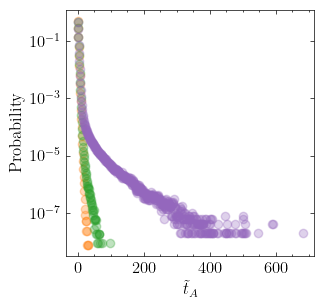

In [145]:
from collections import Counter
from lifetime_distribution import lifetime_distribution
N = 300; t_max = 10_000; t_trans = 200

fig, ax = plt.subplots()
ax.set(
    xlabel=r"$\tilde{t}_A$",
    ylabel=r"Probability",
    yscale="log",
    # xlim=(-5, 85),
    # ylim=(10**(-7.1), 10)
)
for alpha, c in zip([1, .8, .3], ["tab:orange", "tab:green", "tab:purple"]):
    sl = SporeLife(random_init_grid(N, seed=100), alpha=alpha)
    distr: Counter = lifetime_distribution(ALIVE, sl, t_max, t_trans)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    vals_sort_permut = vals.argsort()
    vals, probs = vals[vals_sort_permut], counts[vals_sort_permut]/np.sum(counts)
    # popt, _ = curve_fit(exponential_law, vals[int(len(vals)/2):], probs[int(len(vals)/2):], p0=(10**(-4), 4))
    ax.scatter(vals, probs, alpha=0.3, c=c)
    # ax.plot(vals, exponential_law(vals, *popt), c=c,
    #         label=r"$\alpha = %.1f$: $%.2f\cdot\mathrm{e}^{-t/%.2f}$"%(alpha, popt[0], popt[1]))
ax.legend(loc="upper right")

..............................

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


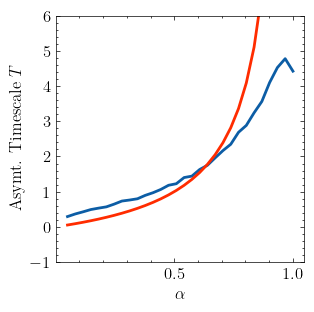

In [ ]:
# Timescale over alpha ~ 4 min
N = 200; t_max = 10_000; t_trans = 200
alphas = np.linspace(0.05, 1, 30)
data = []
for alpha in alphas:
    dl = SporeLife(random_init_grid(N), alpha=alpha)
    distr: Counter = lifetime_distribution(SPORE, dl, t_max, t_trans)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    popt, _ = curve_fit(exponential_law, vals[int(len(vals)/3):], counts[int(len(vals)/3):], p0=(100_000, 1))
    print(".", end="", flush=True)
    data.append(popt[1])

fig, ax = plt.subplots()
ax.set(
    # yscale="log",
    # xscale="log",
    xlabel=r"$\alpha$", ylabel=r"Asymt. Timescale $T$",
    ylim=(-1, 6)
)
ax.plot(alphas, data)
ax.plot(alphas[:-1], alphas[:-1]/(1-alphas[:-1]))
ax.legend()

# Distribution of ALIVE cells

Distribution of the number of ALIVE cells, averaged over time.

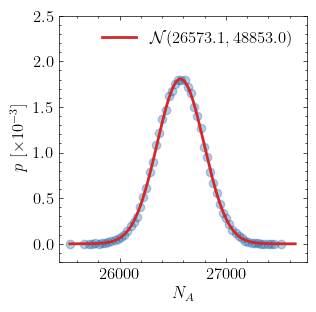

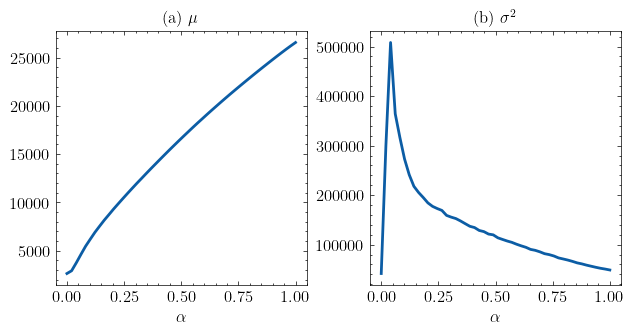

In [166]:
from collections import Counter
grid_size = 300
base_path = f"data/spore-life/time-series/grid-size-{grid_size}/alive"
alphas = np.loadtxt(f"data/spore-life/time-series/grid-size-{grid_size}/alpha-range.dat")

def compute_state_count_distr(alpha, t_trans, base_path):
    alive_cell_data = np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[:, t_trans:]
    alive_cell_data = np.ravel(alive_cell_data)
    distr = Counter(alive_cell_data)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    # Sort
    vals_sort_permut = vals.argsort()
    return vals[vals_sort_permut], counts[vals_sort_permut]

t_trans = 300
alpha = 1.0
vals, counts = compute_state_count_distr(alpha, t_trans, base_path)
probs = counts / np.sum(counts)

fig, ax = plt.subplots()
ax.set(xlabel=r"$N_A$", ylabel=r"$p\:\left[\times 10^{-3}\right]$",
       ylim=(-0.2, 2.5)
)
ax.scatter(vals[::30], probs[::30]*1000, alpha=.3)
popt, _ = curve_fit(gaussian, vals, probs, p0=(5000+20_000*alpha, 1000))
ax.plot(vals, gaussian(vals, *popt)*1000, c="tab:red", label=r"$\operatorname{\mathcal{N}}(%.1f, %.1f)$"%(popt[0], popt[1]**2))
ax.legend()

mus, sigs = [], []
for alpha in alphas:
    vals, counts = compute_state_count_distr(alpha, t_trans, base_path)
    mu, sig = curve_fit(gaussian, vals, counts/np.sum(counts), p0=(5000+20_000*alpha, 1000))[0]
    mus += [mu]; sigs += [sig]
mus, sigs = np.array(mus), np.array(sigs)

fig, (axl, axr) = plt.subplots(figsize=(7.3, 3.3), ncols=2)
axl.set(title=r"(a) $\mu$", xlabel=r"$\alpha$")
axr.set(title=r"(b) $\sigma^2$", xlabel=r"$\alpha$")
axl.plot(alphas, mus)
axr.plot(alphas, sigs**2)

# Extinction Times

In [321]:
def load_extinction_time_data(alpha, cleaned=True, subdir="spore-life"):
    base_path = f"./data/{subdir}/extinction-time/"
    fname = f"alpha-p{str(alpha)[2:]}.dat"
    data = np.loadtxt(os.path.join(base_path, fname))
    if cleaned:
        return data[data>0]
    return data

def gen_normalized_histogram(data: np.array, bin_min: float, bin_max: float,
                             bin_number: int) -> tuple[np.array, np.array]:
    """
    Generate a normalized histogram from data. Returns tuple with lower
    bin bounds (suitable for bar plot with kw align: "edge") and
    respective probabilities.
    """
    bins = np.arange(bin_min, bin_max, bin_max / bin_number)
    counts, bin_edges = np.histogram(data, bins=bins)
    probs = counts / len(data)
    return bin_edges[:-1], probs

def gen_adap_bin_histrogram(data: np.array,
                            data_per_bin: int,
                            strip_data: bool = True) -> tuple[np.array, np.array]:
    """
    Generate a normalized histogram from data with adaptive binning. Each bin
    holds data_per_bin data points. Therefore, bins are smaller in regions with
    a lot of data and larger in regions with scarce data. Returns tuple with
    center positions of bins (suitable for bar plot with kw align: "center") and
    respective probabilities, given by data_per_bin / bin_widths.
    If strip_data is True, the data is stripped (from the end of the sorted
    data array) to ensure that data fits into bins with data_per_bin data points.
    Note: If strip_data is False, the user has to ensure that the length of data
    fits with data_per_bin.
    """
    sorted_data = np.sort(data)
    bin_number = int(len(sorted_data) / data_per_bin)
    if strip_data:
        strip_idx = bin_number * data_per_bin
        sorted_data = sorted_data[:strip_idx]
    assert len(sorted_data) % data_per_bin == 0
    binned_data = np.reshape(sorted_data, (bin_number, data_per_bin))
    # Positions of bins on x-axis
    means = np.mean(binned_data, axis=1)
    bin_widths = binned_data[:, -1] - binned_data[:, 0]
    # Heights of the bars in bar chart
    probs = 1 / bin_widths
    return means, probs


[0.01202777 0.92448615]
[0.00382513 0.94657011]
[0.00168972 0.94501002]
[Text(0.0, 0, '0.0'), Text(0.2, 0, '0.2'), Text(0.3, 0, '0.3'), Text(0.35, 0, '0.35'), Text(0.4, 0, '0.4')]


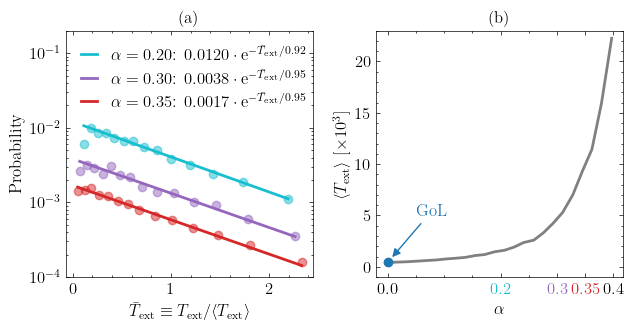

In [347]:
fig, (axl, axr) = plt.subplots(1, 2, figsize=(7.2, 3.2))
### LEFT ###
axl.set(xlabel=r"$\bar{T}_\mathrm{ext} \equiv T_\mathrm{ext} / \langle T_\mathrm{ext} \rangle$",
        title="(a)",
        ylabel="Probability",
        ylim=(1*10**(-4), 2*10**(-1)),
        yscale="log",
        box_aspect=1
        )
alphas_l = [0.2, 0.3, 0.35]
color_cycle = ["tab:cyan", "tab:purple", "tab:red"]
legend_handles = []
for alpha, c in zip(alphas_l, color_cycle):
    data = load_extinction_time_data(alpha)
    avg_extinction_time = np.mean(data)
    bin_centers, probs = gen_adap_bin_histrogram(data, 200)
    axl.scatter(bin_centers/avg_extinction_time, probs,
                color=c, alpha=.5,
                # label=r"$\alpha = %.2f$"%alpha,
                )
    # Fit
    popt, _ = curve_fit(exponential_law,
                        (bin_centers/avg_extinction_time)[3:], probs[3:])
    print(popt)
    axl.plot(bin_centers/avg_extinction_time,
             exponential_law(bin_centers/avg_extinction_time, *popt), color=c,
             label=r"$\alpha = %.2f$: $%.4f\cdot\mathrm{e}^{-\bar{T}_\mathrm{ext}/%.2f}$"%(alpha, popt[0], popt[1]))
#     label_text = r"$\alpha = %.2f$: $%.3f\cdot\exp(x/%.1f)$"%(alpha, popt[0], popt[1])
#     legend_handles.append(mpl.lines.Line2D([],[], c=c, marker="o", label=label_text))
# Legend
axl.legend(handlelength=1, loc=(0.03, 0.65))
### RIGHT ###
axr.set(xlabel=r"$\alpha$",
        ylabel=r"$\langle T_\mathrm{ext} \rangle$ $\left[\times 10^3\right]$",
        title="(b)",
        ylim=(-1, 23),
        box_aspect=1,
        # yscale="log"
)
alphas = np.loadtxt("./data/spore-life/extinction-time/alpha-range.dat")
# Data above alpha = 0.4 numerically biased. Extinction times too long.
alphas = alphas[alphas<0.4]
extinction_times = np.array([np.mean(load_extinction_time_data(alpha)) for alpha in alphas])/1000
# axr.plot(-1/np.log(alphas[1:]), extinction_times[1:], color="gray")
axr.plot(alphas, extinction_times, color="gray")
# Draw marker for Game of Life
axr.annotate("GoL", (0, extinction_times[0]), xytext=(0.05, 5),
            arrowprops={"arrowstyle":"-|>", "relpos":(0.5, 0.5),
                        "color":"tab:blue", "shrinkB":5},
            c="tab:blue")
axr.scatter(x=0, y=extinction_times[0], c="tab:blue", zorder=10)
# Mark alphas from axl
axr.set_xticks([0.0, 0.2, 0.3, 0.35, 0.4], labels=["0.0", "0.2", "0.3", "0.35", "0.4"])
xtick_labels = axr.get_xticklabels()
xtick_labels[1].set_color(color_cycle[0])
xtick_labels[2].set_color(color_cycle[1])
xtick_labels[3].set_color(color_cycle[2])
# axr.scatter(x=0.2, y=np.mean(load_extinction_time_data(0.2))/1000, c="tab:cyan", zorder=10, alpha=0.5)
# axr.vlines(0.2, -1, np.mean(load_extinction_time_data(0.2))/1000, colors="tab:cyan", linestyles=":")
# axr.scatter(x=0.3, y=np.mean(load_extinction_time_data(0.3))/1000+0.4, c="tab:purple", zorder=10, alpha=0.5)
# axr.vlines(0.3, -1, np.mean(load_extinction_time_data(0.3))/1000, colors="tab:purple", linestyles=":")
# axr.scatter(x=0.35, y=np.mean(load_extinction_time_data(0.35))/1000+0.7, c="tab:red", zorder=10, alpha=0.5)
# axr.vlines(0.35, -1, np.mean(load_extinction_time_data(0.35))/1000, colors="tab:red", linestyles=":")
fig.savefig("img/extinction-times.pdf", bbox_inches="tight")

# Time Series

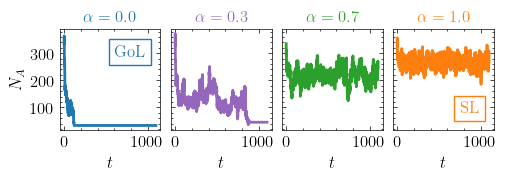

In [305]:
base_path = "data/spore-life/time-series/grid-size-30/"

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(3.2*1.75, 7.2*1.75))
fig.subplots_adjust(wspace=0.1)
axs[0].set(box_aspect=1, xlabel=r"$t$", ylabel=r"$N_A$")
axs[1].set(box_aspect=1, xlabel=r"$t$")
axs[2].set(box_aspect=1, xlabel=r"$t$")
axs[3].set(box_aspect=1, xlabel=r"$t$") 

alphas = [0, 0.306, 0.714, 1]
colors = ["tab:blue", "tab:purple", "tab:green", "tab:orange"]
t_max = 1100
for ax, alpha, c in zip(axs.flatten(), alphas, colors):
    ax.set_title(r"$\alpha=%.1f$"%alpha, c=c)
    time_series = np.loadtxt(os.path.join(base_path, "alive/alpha-%.3f.dat"%alpha))[0, :t_max]
    ax.plot(time_series, c=c)
    if alpha == 0:
        ax.text(600, 290, "GoL", c=c, bbox={"ec": c, "fc": "white"})
    if alpha == 1:
        ax.text(750, 80, "SL", c=c, bbox={"ec": c, "fc": "white"})
fig.savefig("img/time-series.pdf", bbox_inches="tight")

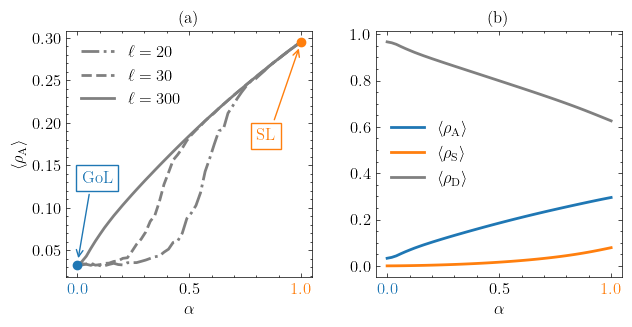

In [361]:
t_trans = 200
base_path = "data/spore-life/time-series"
alphas = np.loadtxt(os.path.join(base_path, "grid-size-300/alpha-range.dat"))
density_300 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-300/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(300**2) for alpha in alphas])
density_100 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-100/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(100**2) for alpha in alphas])
density_30 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-30/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(30**2) for alpha in alphas])
density_20 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-20/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(20**2) for alpha in alphas])

spore_density_300 = np.array([np.mean(np.loadtxt(os.path.join(base_path, f"grid-size-300/spore", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(300**2) for alpha in alphas])
dead_density_300 = 1 - density_300 - spore_density_300

fig, (axl, axr) = plt.subplots(figsize=(7.2, 3.2), ncols=2)
axl.set(xlabel=r"$\alpha$", ylabel=r"$\langle\rho_\mathrm{A}\rangle$", box_aspect=1, title="(a)")
axl.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axl.get_xticklabels()
xtick_labels[0].set_color("tab:blue")
xtick_labels[2].set_color("tab:orange")
axl.plot(alphas, density_20, label=r"$\ell = 20$", linestyle="-.", c="gray")
axl.plot(alphas, density_30, label=r"$\ell = 30$", linestyle="--", c="gray")
# axl.plot(alphas, density_100, label=r"$N=100$", linestyle="-", c="gray")
axl.plot(alphas, density_300, label=r"$\ell=300$", linestyle="-", c="gray")
axl.annotate("GoL", (0, density_300[0]), xytext=(.02, .13),
                arrowprops={"arrowstyle":"->", "relpos":(0.3, 0.1),
                            "color":"tab:blue", "shrinkB":5},
                bbox={"ec": "tab:blue", "fc": "white"},
                c="tab:blue", # backgroundcolor="w", bbox={"ec": "tab:blue", "fc": "white"}
            ) # edge color and face color
axl.scatter(x=0, y=density_300[0], c="tab:blue", zorder=10)
axl.annotate("SL", (1, density_300[-1]), xytext=(.8, .18),
            arrowprops={"arrowstyle":"->", "relpos":(0.65, 0.5),
                        "color":"tab:orange", "shrinkB":5},
            bbox={"ec": "tab:orange", "fc": "white"},
            c="tab:orange")
axl.scatter(x=1, y=density_300[-1], c="tab:orange", zorder=10)
axl.legend()

axr.set(xlabel=r"$\alpha$", box_aspect=1, title="(b)")
axr.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axr.get_xticklabels()
xtick_labels[0].set_color("tab:blue")
xtick_labels[2].set_color("tab:orange")
axr.plot(alphas, density_300, c="tab:blue", label=r"$\langle \rho_\mathrm{A}\rangle$")
axr.plot(alphas, spore_density_300, c="tab:orange", label=r"$\langle \rho_\mathrm{S}\rangle$")
axr.plot(alphas, dead_density_300, c="gray", label=r"$\langle \rho_\mathrm{D}\rangle$")
axr.legend()

fig.savefig("img/finite-size-effects.pdf", bbox_inches="tight")

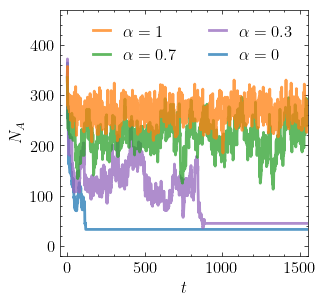

In [249]:
base_path = "data/spore-life/time-series/grid-size-30/"
alpha_0 = np.loadtxt(os.path.join(base_path, "alive/alpha-%.3f.dat"%0))[0, :]
alpha_1 = np.loadtxt(os.path.join(base_path, "alive/alpha-%.3f.dat"%1))[0, :]
alpha_p3 = np.loadtxt(os.path.join(base_path, "alive/alpha-%.3f.dat"%0.306))[0, :]
alpha_p7 = np.loadtxt(os.path.join(base_path, "alive/alpha-%.3f.dat"%0.714))[0, :]

fig, ax = plt.subplots()
ax.set(xlim=(-50, 1550), ylim=(-20, 470), xlabel=r"$t$", ylabel=r"$N_A$")
ax.plot(alpha_0, label=r"$\alpha = 0$", c="tab:blue", alpha=0.75)
ax.plot(alpha_p3, label=r"$\alpha = 0.3$", c="tab:purple", alpha=0.75)
ax.plot(alpha_p7, label=r"$\alpha = 0.7$", c="tab:green", alpha=0.75)
ax.plot(alpha_1, label=r"$\alpha = 1$", c="tab:orange", alpha=0.75)

handles, labels = fig.gca().get_legend_handles_labels()
order = range(3,-1,-1)
ax.legend([handles[i] for i in order], [labels[i] for i in order],
          ncol=2, handlelength=1.)

# Birth Rate and Death Rate

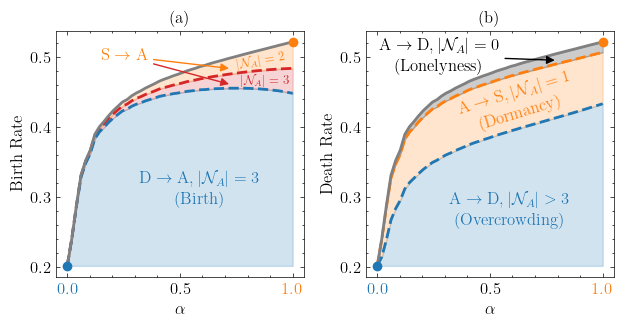

In [363]:
t_max = 10_000; t_trans = 200; runs = 30

base_path = "data/spore-life/state-transitions/transition-table/grid-size-300/"
alphas = np.loadtxt(os.path.join(base_path, "alpha-range.dat"))

# DATA
# birth rate (br)
_mask_2an = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0]])
_mask_3an_spore = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0]])
_mask_3an_dead = np.bool_([[0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]])
transitions_2an = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_2an]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_3an_spore = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_3an_spore]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_3an_dead = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_3an_dead]) for alpha in alphas])/((t_max-t_trans)*runs)
birth_rate_2an = transitions_2an / (density_300*(300**2))
birth_rate_3an_spore = transitions_3an_spore / (density_300*(300**2))
birth_rate_3an_dead = transitions_3an_dead / (density_300*(300**2))
birth_rate = birth_rate_2an + birth_rate_3an_spore + birth_rate_3an_dead

br_baseline = birth_rate[0]
br_2an_area_percent = (birth_rate-br_baseline)*birth_rate_2an/birth_rate
br_3an_spore_area_percent = (birth_rate-br_baseline)*birth_rate_3an_spore/birth_rate
br_3an_dead_area_percent = (birth_rate-br_baseline)*birth_rate_3an_dead/birth_rate

# death rate (dr)
_mask_spore = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0]])
_mask_lonely = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [1, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0]])
_mask_overcrowd = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, 1, 1, 1, 1],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0]])
# transitions_to_dead = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_spore = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_spore]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_lonely = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_lonely]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_overcrowd = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_overcrowd]) for alpha in alphas])/((t_max-t_trans)*runs)
death_rate_spore = transitions_spore / (density_300*(300**2))
death_rate_lonely = transitions_lonely / (density_300*(300**2))
death_rate_overcrowd = transitions_overcrowd / (density_300*(300**2))
death_rate = death_rate_spore + death_rate_lonely + death_rate_overcrowd

dr_baseline = death_rate[0]
overcrowd_area_percent = (death_rate-dr_baseline)*death_rate_overcrowd/death_rate
spore_area_percent =  (death_rate-dr_baseline)*death_rate_spore/death_rate
lonely_area_percent = (death_rate-dr_baseline)*death_rate_lonely/death_rate

# PLOT
fig, (axl, axr) = plt.subplots(figsize=(7.2, 3.2), ncols=2)
axl.set(xlabel=r"$\alpha$", ylabel=r"Birth Rate")
axl.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axl.get_xticklabels()
xtick_labels[0].set_color("tab:blue")
xtick_labels[2].set_color("tab:orange")
axl.set_title("(a)", loc="center")

axl.plot(alphas, br_baseline+br_3an_dead_area_percent+br_3an_spore_area_percent, linestyle="--", c="tab:red")
axl.plot(alphas, br_baseline+br_3an_dead_area_percent, linestyle="--", c="tab:blue")
axl.plot(alphas, birth_rate, c="gray")

axl.fill_between(alphas, [br_baseline]*len(alphas), br_baseline+br_3an_dead_area_percent, alpha=0.2, zorder=-1, color="tab:blue")
axl.fill_between(alphas, br_baseline+br_3an_dead_area_percent, br_baseline+br_3an_dead_area_percent+br_3an_spore_area_percent, alpha=0.2, zorder=-1, color="tab:red")
axl.fill_between(alphas, br_baseline+br_3an_dead_area_percent+br_3an_spore_area_percent, birth_rate, alpha=0.2, zorder=-1, color="tab:orange")
# axl.annotate("Game of Life", (0, birth_rate[0]), xytext=(.15, .25),
#             arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
#                         "color":"tab:blue", "shrinkB":10},
#             c="tab:blue") # edge color and face color
axl.scatter(x=0, y=birth_rate[0], c="tab:blue", zorder=10)
# axl.annotate("Dormant Life", (1, birth_rate[-1]), xytext=(.55, .4),
#             arrowprops={"arrowstyle":"->", "relpos":(0.65, 0.5),
#                         "color":"tab:orange", "shrinkB":5},
#             c="tab:orange")
axl.scatter(x=1, y=birth_rate[-1], c="tab:orange", zorder=10)
axl.text(0.32, 0.32, r"\begin{center}$\mathrm{D}\to\mathrm{A}, |\mathcal{N}_A|=3$ \\ (Birth)\end{center}", c="tab:blue")
axl.text(0.75, 0.485, r"$|\mathcal{N}_A|=2$", c="tab:orange", fontsize=9, rotation=10)
axl.text(0.77, 0.462, r"$|\mathcal{N}_A|=3$", c="tab:red", fontsize=9, rotation=0)
axl.annotate(r"$\mathrm{S}\to\mathrm{A}$", (0.73, 0.460), xytext=(0.15, 0.495),
            arrowprops={"arrowstyle":"-|>", "relpos":(.5,.5),
                        "color":"tab:red"},
            c="tab:orange", zorder=20)
axl.annotate(r"$\mathrm{S}\to\mathrm{A}$", (0.73, 0.483), xytext=(0.15, 0.495), alpha=0,
            arrowprops={"arrowstyle":"-|>", "relpos":(.5,.5),
                        "color":"tab:orange"},
            c="tab:red", zorder=20)

axr.set(xlabel=r"$\alpha$", ylabel=r"Death Rate", title="(b)")
axr.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axr.get_xticklabels()
xtick_labels[0].set_color("tab:blue")
xtick_labels[2].set_color("tab:orange")
axr.plot(alphas, dr_baseline+overcrowd_area_percent+spore_area_percent, c="tab:orange", ls="--")
axr.plot(alphas, dr_baseline+overcrowd_area_percent, c="tab:blue", ls="--")
axr.plot(alphas, death_rate, c="gray")
axr.fill_between(alphas, [dr_baseline]*len(alphas),
                dr_baseline+overcrowd_area_percent,
                alpha=0.2, zorder=-1, color="tab:blue")
axr.fill_between(alphas, dr_baseline+overcrowd_area_percent, 
                dr_baseline+overcrowd_area_percent+spore_area_percent,
                alpha=0.2, zorder=-1, color="tab:orange")
axr.fill_between(alphas, dr_baseline+overcrowd_area_percent+spore_area_percent, 
                death_rate,
                alpha=0.2, zorder=-1, color="black")
axr.scatter(x=0, y=death_rate[0], c="tab:blue", zorder=10)
axr.scatter(x=1, y=death_rate[-1], c="tab:orange", zorder=10)
axr.text(0.32, 0.29, r"\begin{center}$\mathrm{A}\to\mathrm{D}, |\mathcal{N}_A|>3$ \\ (Overcrowding)\end{center}", c="tab:blue")
axr.text(0.35, 0.42, r"\begin{center}$\mathrm{A}\to\mathrm{S}, |\mathcal{N}_A|=1$ \\ (Dormancy)\end{center}", c="tab:orange", rotation=17)
axr.annotate(r"\begin{center}$\mathrm{A} \to \mathrm{D}, |\mathcal{N}_A|=0$ \\ (Lonelyness)\end{center}", (0.8, 0.495), xytext=(0.01, 0.51),
            arrowprops={"arrowstyle":"-|>", "relpos":(.5,.5),
                        "color":"black", },
            c="black", zorder=20)

fig.savefig("img/birth-death-rate.pdf", bbox_inches="tight")

# Old

In [ ]:
def DL_alive_cells(grid_size: int, runs: int, t_max: int,
                   alpha: float, base_seed: int = None) -> np.array:
    data = np.zeros((runs, t_max + 1))
    if base_seed is None:
        base_seed = np.random.randint(1)
    for i in range(runs):
        seed = base_seed + i
        rng = np.random.default_rng(seed)
        q = 0.37017384
        init_grid = rng.choice([0, 1], p=[1-q, q], size=[grid_size, grid_size])
        gol = DormantLife(init_grid)
        for j in range(t_max + 1):
            data[i, j] = gol.alive_count
            gol.step(alpha=alpha)
    return data

In [ ]:
grid_size = 30
small_grid_size = 14
runs = 100
t_max = 5000
times = np.arange(t_max + 1)
base_seed = 100

In [ ]:
data_1 = np.mean(DL_alive_cells(grid_size, runs, t_max, 1, base_seed), axis=0)
data_p75 = np.mean(DL_alive_cells(grid_size, runs, t_max, .75, base_seed), axis=0)
data_p5 = np.mean(DL_alive_cells(grid_size, runs, t_max, .5, base_seed), axis=0)
data_p35 = np.mean(DL_alive_cells(grid_size, runs, t_max, .35, base_seed), axis=0)
data_p25 = np.mean(DL_alive_cells(grid_size, runs, t_max, .25, base_seed), axis=0)
data_p1 = np.mean(DL_alive_cells(grid_size, runs, t_max, .1, base_seed), axis=0)
data_0 = np.mean(DL_alive_cells(grid_size, runs, t_max, 0, base_seed), axis=0)

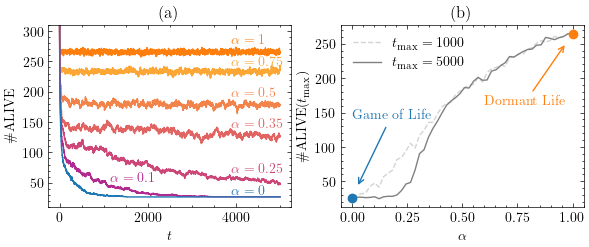

In [ ]:
grid_size = 30
small_grid_size = 14
runs = 100
t_max = 5000
times = np.arange(t_max + 1)
base_seed = 100

alphas = [data_1,data_p75,data_p5,data_p35,data_p25,data_p1,data_0]
colors = ["tab:orange",
        *mpl.colormaps["plasma"](np.linspace(0.8, 0.4, 5)),
        "tab:blue"]
label_texts = [r"$\alpha = 1$", r"$\alpha = 0.75$", r"$\alpha = 0.5$",
                r"$\alpha = 0.35$", r"$\alpha = 0.25$", r"$\alpha = 0.1$",
                r"$\alpha = 0$"]
x_offsets = [0, 0, 0, 0, 0, -2750, 0]
y_offsets = [15, 2, 15, 15, 18, 25, 5]

def plot_time_series(ax, x, y, label_text, color, x_offset, y_offset):
    ax.plot(x, y, color=color)
    ax.text(x[-int(len(x)/4.5)]+x_offset, y[-1]+y_offset, label_text,
            color=color)

fig, (axl, axr) = plt.subplots(figsize=(6,3), ncols=2)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=None)
fig.tight_layout()
axl.set(title="(a)", box_aspect=3/4, ylim=(10,310))
axr.set(title="(b)", box_aspect=3/4)
axl.set(xlabel=r"$t$", ylabel=r"$\#\text{ALIVE}$")
for alpha, label_text, color, x_offset, y_offset in zip(alphas,
                                                        label_texts,
                                                        colors,
                                                        x_offsets,
                                                        y_offsets):
    data = alpha
    plot_time_series(axl, times, data, label_text, color, x_offset, y_offset)

alphas, N_alive_t_1000, N_alive_final = np.loadtxt("./data/phase_transition_2.dat")
axr.set(xlabel=r"$\alpha$", ylabel=r"$\#\text{ALIVE}(t_\text{max})$")
axr.plot(alphas, N_alive_t_1000, label=r"$t_\mathrm{max} = 1000$", color="lightgray", linestyle="--")
axr.plot(alphas, N_alive_final, label=r"$t_\mathrm{max} = 5000$", color="gray")
axr.annotate("Game of Life", (0, N_alive_final[0]), xytext=(0., 140),
            arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
                        "color":"tab:blue", "shrinkB":10},
            c="tab:blue")
axr.scatter(x=0, y=N_alive_final[0], c="tab:blue", zorder=10)
axr.annotate("Dormant Life", (1, N_alive_final[-1]), xytext=(.6, 160),
            arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
                        "color":"tab:orange", "shrinkB":10},
            c="tab:orange")
axr.scatter(x=1, y=N_alive_final[-1], c="tab:orange", zorder=10)
axr.legend()
fig.savefig("./img/phase_transition", dpi=500)

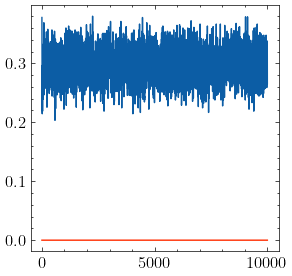

In [ ]:
t_max = 10000
alpha = 1
N = 30
q = 0.37017384
init_grid = np.random.choice([0, 1], p=[1-q, q], size=[N, N])
gol = DormantLife(init_grid, alpha=alpha)
data = np.zeros(t_max)
while gol.t < t_max:
    data[gol.t] = gol.count_state(1)
    gol.step()
fig, ax = plt.subplots()
ax.plot(np.arange(t_max), data/N**2)
ax.plot(np.arange(t_max), [0]*t_max)
# ax.set(xlim=(8000,10000))